In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import re
import nltk
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
nltk.download('wordnet')
nltk.download('ombw-1.4')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Error loading ombw-1.4: Package 'ombw-1.4' not found in
[nltk_data]     index
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Data Preparation

Stock returns from S&P 500 and market return are downloaded from WRDS. The date range is from 2016 to 2021. Value-Weighted Return with Distribution (VWRETD) is collected for market data to calcualte four-days' excess return.  

In [4]:
# Read data downloaded from WRDS
market_return = pd.read_csv('market_return.csv')
stock_returns = pd.read_csv('return_with_PERMNO.csv')

# Calculate 4-days' excess return
pv = pd.pivot(stock_returns[['date', 'PERMNO', 'RETX']], index='date', columns='PERMNO')['RETX']
four_day_return = (pv+1)*(pv.shift(-1)+1)*(pv.shift(-2)+1)*(pv.shift(-3)+1)-1
market_return.set_index('caldt', inplace=True)
four_day_market_return = (market_return+1)*(market_return.shift(-1)+1)*(market_return.shift(-2)+1)*(market_return.shift(-3)+1)-1
excess_return = four_day_return.sub(four_day_market_return['vwretd'], axis='index')
excess_return.index = excess_return.index.astype('str')
excess_return.columns = excess_return.columns.astype('int')
excess_return.index = pd.to_datetime(excess_return.index)
excess_return = excess_return.resample('D').mean().fillna(method='bfill')
excess_return.index = excess_return.index.strftime('%Y%m%d')
excess_return.head()

PERMNO,10104,10107,10138,10145,10147,10299,10516,10696,10909,11308,...,92890,93002,93089,93096,93132,93159,93246,93422,93429,93436
date,,,,,,,,,,,,,,,,,,,,,
20160104,0.007542,-0.011331,-0.013636,0.006428,0.016009,-0.028900,-0.010558,0.012796,0.006783,0.017139,...,0.006405,-0.062589,-0.001617,0.047913,-0.015833,-0.106315,-0.010117,-0.059878,0.016897,-0.053166
20160105,0.013414,-0.000890,-0.024630,0.003821,0.000415,-0.034369,0.003725,0.022172,0.054156,0.023193,...,-0.020923,-0.054777,0.018552,0.031063,-0.009406,-0.150908,0.012707,-0.091030,0.021679,-0.011366
20160106,0.025566,-0.004747,-0.032403,-0.003047,0.002479,-0.023017,-0.012189,0.023296,0.031089,0.022410,...,-0.045057,-0.023728,0.032013,0.001407,-0.004726,-0.164329,0.059174,-0.114181,0.047583,-0.024524
20160107,0.013017,0.002084,-0.006204,-0.004447,0.002213,-0.000067,-0.005246,0.026477,0.052307,0.020854,...,-0.062549,0.000297,0.024107,-0.001651,-0.000521,-0.134420,0.082264,-0.064020,0.044792,-0.015828
20160108,-0.000204,0.017035,-0.005463,0.005728,0.000635,0.019540,-0.003224,0.011550,0.038638,0.032720,...,-0.059400,-0.017285,0.011449,-0.019576,0.000454,-0.156512,0.052525,-0.063183,0.024807,-0.043941


As stock returns are downloaded using PERMNO, while 10-Ks and 10-Qs are extracted based on CIK. The lookup table is created to map one from the other. 

In [5]:
# Read stock information to map CIK to PERMNO
PERMNO_CIK_lookup_t = pd.read_csv('sp500_w_addl_id_with_cik.csv', usecols=['cik', 'permno']).drop_duplicates()
PERMNO_CIK_lookup_t = PERMNO_CIK_lookup_t.dropna().astype('int').set_index('cik').squeeze()
PERMNO_CIK_lookup_t = PERMNO_CIK_lookup_t.astype(int)
PERMNO_CIK_lookup_t.head()

cik
814453    60986
764478    85914
922864    80711
4962      59176
98246     75100
Name: permno, dtype: int64

## 10-Ks and 10-Qs Data Preprocessing

We write steps to process 10-Ks and 10-Qs as follows. Noticed that due to the limitation in local storage and I-O timing, we devided to call those functions immediately after downloading html document. Therefore, only lemmatized version of word lists is saved for later calculation instead of the raw file. 

The script used to download 10-Ks and 10-Qs is attached, which called lemmatization process accordingly. 

Here we only show a demo example to explain the process.

In [6]:
def remove_html_tags(text):
    bs = BeautifulSoup(text, 'html.parser')
    # Remove all images and table
    for tag in ["table", "img", "IMS-HEADER", "SEC-HEADER"]:
      for ele in bs.find_all(tag):
        ele.extract()
    text = bs.get_text()
    return text
    
def clean_text(text):
    # Convert to lower case
    text = text.lower().strip()
    # Remove HTML tags
    text = remove_html_tags(text)
    return text

# Lemmatize words
def lemmatize_words(words):
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]
    return lemmatized_words

In [8]:
# Lemmatize all raw files and save lemmatized version in drive:
def lemmatize_10K(id):
  # Read raw data in batch
  # Noticed that we stored raw file of 10-Ks and 10-Qs in batch due to storage limitation
  with open(('./10-Ks/statements'+str(id)+'.json'), 'r', encoding='utf-8') as f:
    ten_ks_by_ticker = [item for d in f.read().splitlines() for item in json.loads(d)]

  # Remove html tags
  for ten_k in tqdm(ten_ks_by_ticker):
    try:
      ten_k['file_clean'] = clean_text(ten_k['file'])
    except:
      print("File with id:", id, "cannot be cleaned!")

  # Lemmatize words and remove stopwords
  word_pattern = re.compile('\w+')
  lemma_english_stopwords = lemmatize_words(stopwords.words('english'))
  for ten_k in tqdm(ten_ks_by_ticker):
    try:
      ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))
      ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]
      print('File with date:', ten_k['file_date'], 'and CIK:', ten_k['cik'], 'has lemmatized word list of length:', len(ten_k['file_lemma']))
    except KeyError:
      print('Key error!')

  # Save lemmatized file for future process
  lemmatized_files = [{k: ten_ks[k] for k in ('cik', 'file_date', 'file_lemma')} for ten_ks in ten_ks_by_ticker if 'file_lemma' in ten_ks]
  file_name = './10-Ks/'+'lemmatized_files_'+str(id)+'.json'
  with open(file_name, "w") as outfile:
    json.dump(lemmatized_files, outfile)

In [9]:
# Demo used to show output
ids = [0]
for id in ids:
  lemmatize_10K(id)

 82%|████████▏ | 184/224 [17:01<03:14,  4.87s/it]/usr/local/lib/python3.7/dist-packages/bs4/builder/_htmlparser.py:78: UserWarning: unknown status keyword 'q7p' in marked section
  warnings.warn(msg)
 83%|████████▎ | 185/224 [17:11<04:03,  6.24s/it]

File with id: 0 cannot be cleaned!


 84%|████████▍ | 188/224 [18:03<08:23, 13.98s/it]/usr/local/lib/python3.7/dist-packages/bs4/builder/_htmlparser.py:78: UserWarning: unknown status keyword 'a' in marked section
  warnings.warn(msg)
 84%|████████▍ | 189/224 [18:06<06:06, 10.46s/it]

File with id: 0 cannot be cleaned!


 85%|████████▌ | 191/224 [18:38<06:39, 12.12s/it]

File with id: 0 cannot be cleaned!


 86%|████████▌ | 193/224 [19:12<06:48, 13.17s/it]

File with id: 0 cannot be cleaned!


  0%|          | 1/224 [00:00<01:38,  2.26it/s]

File with date: 2020-03-02 and CIK: 0000814453 has lemmatized word list of length: 41736


  1%|          | 2/224 [00:00<01:29,  2.47it/s]

File with date: 2019-03-04 and CIK: 0000814453 has lemmatized word list of length: 28782


  1%|▏         | 3/224 [00:01<01:25,  2.59it/s]

File with date: 2018-03-01 and CIK: 0000814453 has lemmatized word list of length: 28995


  2%|▏         | 4/224 [00:01<01:29,  2.45it/s]

File with date: 2017-03-01 and CIK: 0000814453 has lemmatized word list of length: 37390


  2%|▏         | 5/224 [00:02<01:36,  2.27it/s]

File with date: 2016-02-29 and CIK: 0000814453 has lemmatized word list of length: 40439


  3%|▎         | 6/224 [00:02<01:34,  2.32it/s]

File with date: 2015-03-02 and CIK: 0000814453 has lemmatized word list of length: 33768


  3%|▎         | 7/224 [00:02<01:26,  2.50it/s]

File with date: 2020-03-23 and CIK: 0000764478 has lemmatized word list of length: 25423


  4%|▎         | 8/224 [00:03<01:20,  2.69it/s]

File with date: 2019-03-28 and CIK: 0000764478 has lemmatized word list of length: 24562


  4%|▍         | 9/224 [00:03<01:15,  2.86it/s]

File with date: 2018-04-02 and CIK: 0000764478 has lemmatized word list of length: 24021


  4%|▍         | 10/224 [00:03<01:10,  3.01it/s]

File with date: 2017-03-24 and CIK: 0000764478 has lemmatized word list of length: 23244


  5%|▍         | 11/224 [00:04<01:10,  3.04it/s]

File with date: 2016-03-23 and CIK: 0000764478 has lemmatized word list of length: 24379


  5%|▌         | 12/224 [00:04<01:09,  3.07it/s]

File with date: 2015-03-31 and CIK: 0000764478 has lemmatized word list of length: 25953


  6%|▌         | 13/224 [00:04<01:09,  3.04it/s]

File with date: 2020-02-24 and CIK: 0000922864 has lemmatized word list of length: 31157


  6%|▋         | 14/224 [00:05<01:07,  3.12it/s]

File with date: 2019-02-20 and CIK: 0000922864 has lemmatized word list of length: 25293


  7%|▋         | 15/224 [00:05<01:04,  3.24it/s]

File with date: 2018-03-01 and CIK: 0000922864 has lemmatized word list of length: 25645


  7%|▋         | 16/224 [00:05<01:04,  3.23it/s]

File with date: 2017-02-24 and CIK: 0000922864 has lemmatized word list of length: 25539


  8%|▊         | 17/224 [00:05<01:03,  3.28it/s]

File with date: 2016-02-29 and CIK: 0000922864 has lemmatized word list of length: 26298


  8%|▊         | 18/224 [00:06<01:02,  3.28it/s]

File with date: 2015-02-27 and CIK: 0000922864 has lemmatized word list of length: 26492


  8%|▊         | 19/224 [00:06<01:14,  2.76it/s]

File with date: 2020-02-13 and CIK: 0000004962 has lemmatized word list of length: 45473


  9%|▉         | 20/224 [00:07<01:18,  2.59it/s]

File with date: 2019-02-13 and CIK: 0000004962 has lemmatized word list of length: 38737


  9%|▉         | 21/224 [00:07<01:23,  2.43it/s]

File with date: 2018-02-16 and CIK: 0000004962 has lemmatized word list of length: 40693


 10%|▉         | 22/224 [00:08<01:27,  2.30it/s]

File with date: 2017-02-17 and CIK: 0000004962 has lemmatized word list of length: 39857


 10%|█         | 23/224 [00:08<01:35,  2.11it/s]

File with date: 2016-02-19 and CIK: 0000004962 has lemmatized word list of length: 48483


 11%|█         | 24/224 [00:09<01:30,  2.21it/s]

File with date: 2015-02-24 and CIK: 0000004962 has lemmatized word list of length: 33459


 11%|█         | 25/224 [00:09<01:24,  2.35it/s]

File with date: 2020-03-20 and CIK: 0000098246 has lemmatized word list of length: 32942


 12%|█▏        | 26/224 [00:10<01:32,  2.14it/s]

File with date: 2019-03-22 and CIK: 0000098246 has lemmatized word list of length: 27082


 12%|█▏        | 27/224 [00:10<01:40,  1.97it/s]

File with date: 2018-03-16 and CIK: 0000098246 has lemmatized word list of length: 28021


 12%|█▎        | 28/224 [00:10<01:29,  2.19it/s]

File with date: 2017-03-17 and CIK: 0000098246 has lemmatized word list of length: 27988


 13%|█▎        | 29/224 [00:11<01:38,  1.97it/s]

File with date: 2016-03-28 and CIK: 0000098246 has lemmatized word list of length: 26167


 13%|█▎        | 30/224 [00:11<01:29,  2.17it/s]

File with date: 2015-03-20 and CIK: 0000098246 has lemmatized word list of length: 23511


 14%|█▍        | 31/224 [00:12<01:45,  1.83it/s]

File with date: 2020-08-18 and CIK: 0000730464 has lemmatized word list of length: 42564


 14%|█▍        | 32/224 [00:13<01:40,  1.90it/s]

File with date: 2019-08-28 and CIK: 0000730464 has lemmatized word list of length: 39360


 15%|█▍        | 33/224 [00:13<01:42,  1.87it/s]

File with date: 2018-08-24 and CIK: 0000730464 has lemmatized word list of length: 44969


 15%|█▌        | 34/224 [00:14<01:47,  1.77it/s]

File with date: 2017-08-24 and CIK: 0000730464 has lemmatized word list of length: 44772


 16%|█▌        | 35/224 [00:15<02:04,  1.52it/s]

File with date: 2016-08-25 and CIK: 0000730464 has lemmatized word list of length: 47548


 16%|█▌        | 36/224 [00:16<02:21,  1.33it/s]

File with date: 2015-08-27 and CIK: 0000730464 has lemmatized word list of length: 44285


 17%|█▋        | 37/224 [00:17<02:37,  1.19it/s]

File with date: 2020-03-31 and CIK: 0001018840 has lemmatized word list of length: 24016


 17%|█▋        | 38/224 [00:17<02:14,  1.38it/s]

File with date: 2019-04-01 and CIK: 0001018840 has lemmatized word list of length: 20446


 17%|█▋        | 39/224 [00:18<01:59,  1.54it/s]

File with date: 2018-04-02 and CIK: 0001018840 has lemmatized word list of length: 19818


 18%|█▊        | 40/224 [00:18<01:49,  1.68it/s]

File with date: 2017-03-27 and CIK: 0001018840 has lemmatized word list of length: 19378


 18%|█▊        | 41/224 [00:18<01:33,  1.96it/s]

File with date: 2016-03-28 and CIK: 0001018840 has lemmatized word list of length: 19048


 19%|█▉        | 42/224 [00:19<01:18,  2.31it/s]

File with date: 2015-03-30 and CIK: 0001018840 has lemmatized word list of length: 21592


 19%|█▉        | 43/224 [00:20<01:54,  1.57it/s]

File with date: 2020-02-19 and CIK: 0000070858 has lemmatized word list of length: 85063


 20%|█▉        | 44/224 [00:21<02:10,  1.38it/s]

File with date: 2019-02-26 and CIK: 0000070858 has lemmatized word list of length: 87314


 20%|██        | 45/224 [00:22<02:45,  1.08it/s]

File with date: 2018-02-22 and CIK: 0000070858 has lemmatized word list of length: 62835


 21%|██        | 46/224 [00:23<02:38,  1.12it/s]

File with date: 2017-02-23 and CIK: 0000070858 has lemmatized word list of length: 67272


 21%|██        | 47/224 [00:24<02:50,  1.04it/s]

File with date: 2016-02-24 and CIK: 0000070858 has lemmatized word list of length: 78241


 21%|██▏       | 48/224 [00:26<03:14,  1.10s/it]

File with date: 2015-02-25 and CIK: 0000070858 has lemmatized word list of length: 86503


 22%|██▏       | 49/224 [00:26<02:31,  1.15it/s]

File with date: 2020-03-11 and CIK: 0000027419 has lemmatized word list of length: 15474


 22%|██▏       | 50/224 [00:26<02:03,  1.41it/s]

File with date: 2019-03-13 and CIK: 0000027419 has lemmatized word list of length: 12651


 23%|██▎       | 51/224 [00:26<01:41,  1.70it/s]

File with date: 2018-03-14 and CIK: 0000027419 has lemmatized word list of length: 13804


 24%|██▎       | 53/224 [00:27<01:07,  2.52it/s]

File with date: 2017-03-08 and CIK: 0000027419 has lemmatized word list of length: 12986
File with date: 2016-03-11 and CIK: 0000027419 has lemmatized word list of length: 14262


 24%|██▍       | 54/224 [00:27<00:57,  2.96it/s]

File with date: 2015-03-13 and CIK: 0000027419 has lemmatized word list of length: 14753


 25%|██▍       | 55/224 [00:28<01:03,  2.64it/s]

File with date: 2020-02-14 and CIK: 0001637459 has lemmatized word list of length: 43193


 25%|██▌       | 56/224 [00:28<01:13,  2.28it/s]

File with date: 2019-06-07 and CIK: 0001637459 has lemmatized word list of length: 51657


 25%|██▌       | 57/224 [00:29<01:08,  2.44it/s]

File with date: 2018-02-16 and CIK: 0001637459 has lemmatized word list of length: 28516


 26%|██▌       | 58/224 [00:29<01:24,  1.96it/s]

File with date: 2017-02-23 and CIK: 0001637459 has lemmatized word list of length: 27845


 26%|██▋       | 59/224 [00:30<01:37,  1.70it/s]

File with date: 2016-03-03 and CIK: 0001637459 has lemmatized word list of length: 29262


 27%|██▋       | 60/224 [00:31<01:42,  1.59it/s]

File with date: 2020-02-18 and CIK: 0000064803 has lemmatized word list of length: 61633


 27%|██▋       | 61/224 [00:31<01:29,  1.83it/s]

File with date: 2019-02-28 and CIK: 0000064803 has lemmatized word list of length: 30049


 28%|██▊       | 63/224 [00:32<01:00,  2.67it/s]

File with date: 2018-02-14 and CIK: 0000064803 has lemmatized word list of length: 19045
File with date: 2017-02-09 and CIK: 0000064803 has lemmatized word list of length: 13421


 29%|██▊       | 64/224 [00:32<00:51,  3.11it/s]

File with date: 2016-02-09 and CIK: 0000064803 has lemmatized word list of length: 12469


 29%|██▉       | 66/224 [00:32<00:41,  3.80it/s]

File with date: 2015-02-10 and CIK: 0000064803 has lemmatized word list of length: 10878
File with date: 2017-11-17 and CIK: 0000865436 has lemmatized word list of length: 10621


 30%|██▉       | 67/224 [00:33<00:44,  3.55it/s]

File with date: 2016-11-18 and CIK: 0000865436 has lemmatized word list of length: 17835


 30%|███       | 68/224 [00:33<00:48,  3.20it/s]

File with date: 2015-11-13 and CIK: 0000865436 has lemmatized word list of length: 17896


 31%|███       | 69/224 [00:34<01:09,  2.24it/s]

File with date: 2020-02-28 and CIK: 0000031462 has lemmatized word list of length: 34649


 31%|███▏      | 70/224 [00:34<01:11,  2.16it/s]

File with date: 2019-03-01 and CIK: 0000031462 has lemmatized word list of length: 30905


 32%|███▏      | 71/224 [00:35<01:19,  1.92it/s]

File with date: 2018-02-23 and CIK: 0000031462 has lemmatized word list of length: 32532


 32%|███▏      | 72/224 [00:35<01:13,  2.06it/s]

File with date: 2017-02-24 and CIK: 0000031462 has lemmatized word list of length: 30161


 33%|███▎      | 74/224 [00:36<00:58,  2.55it/s]

File with date: 2016-02-26 and CIK: 0000031462 has lemmatized word list of length: 31867
File with date: 2015-02-27 and CIK: 0000031462 has lemmatized word list of length: 9937


 33%|███▎      | 75/224 [00:37<01:12,  2.05it/s]

File with date: 2020-03-02 and CIK: 0001378946 has lemmatized word list of length: 57453


 34%|███▍      | 76/224 [00:37<01:29,  1.65it/s]

File with date: 2019-03-01 and CIK: 0001378946 has lemmatized word list of length: 46344


 34%|███▍      | 77/224 [00:39<01:53,  1.29it/s]

File with date: 2018-03-01 and CIK: 0001378946 has lemmatized word list of length: 45691


 35%|███▍      | 78/224 [00:39<01:47,  1.35it/s]

File with date: 2017-03-01 and CIK: 0001378946 has lemmatized word list of length: 43552


 35%|███▌      | 79/224 [00:40<01:50,  1.31it/s]

File with date: 2016-02-29 and CIK: 0001378946 has lemmatized word list of length: 42184


 36%|███▌      | 80/224 [00:41<02:09,  1.11it/s]

File with date: 2015-03-02 and CIK: 0001378946 has lemmatized word list of length: 42688


 36%|███▌      | 81/224 [00:43<02:29,  1.04s/it]

File with date: 2020-02-12 and CIK: 0000024545 has lemmatized word list of length: 51985


 37%|███▋      | 82/224 [00:44<02:45,  1.17s/it]

File with date: 2019-02-12 and CIK: 0000024545 has lemmatized word list of length: 44986


 37%|███▋      | 83/224 [00:45<02:32,  1.08s/it]

File with date: 2018-02-14 and CIK: 0000024545 has lemmatized word list of length: 45023


 38%|███▊      | 84/224 [00:46<02:30,  1.08s/it]

File with date: 2017-02-14 and CIK: 0000024545 has lemmatized word list of length: 48019


 38%|███▊      | 85/224 [00:47<02:07,  1.09it/s]

File with date: 2016-02-11 and CIK: 0000024545 has lemmatized word list of length: 44782


 38%|███▊      | 86/224 [00:47<01:48,  1.27it/s]

File with date: 2015-02-12 and CIK: 0000024545 has lemmatized word list of length: 41462


 39%|███▉      | 87/224 [00:48<01:32,  1.48it/s]

File with date: 2020-02-27 and CIK: 0000354908 has lemmatized word list of length: 36765


 39%|███▉      | 88/224 [00:48<01:19,  1.71it/s]

File with date: 2019-02-28 and CIK: 0000354908 has lemmatized word list of length: 29373


 40%|███▉      | 89/224 [00:48<01:12,  1.87it/s]

File with date: 2018-02-23 and CIK: 0000354908 has lemmatized word list of length: 29029


 40%|████      | 90/224 [00:49<01:03,  2.11it/s]

File with date: 2017-02-24 and CIK: 0000354908 has lemmatized word list of length: 27093


 41%|████      | 91/224 [00:49<00:57,  2.31it/s]

File with date: 2016-02-26 and CIK: 0000354908 has lemmatized word list of length: 24432


 41%|████      | 92/224 [00:49<00:51,  2.58it/s]

File with date: 2015-02-27 and CIK: 0000354908 has lemmatized word list of length: 22202


 42%|████▏     | 93/224 [00:50<01:11,  1.82it/s]

File with date: 2020-02-28 and CIK: 0000816761 has lemmatized word list of length: 24943


 42%|████▏     | 94/224 [00:51<01:13,  1.76it/s]

File with date: 2019-02-26 and CIK: 0000816761 has lemmatized word list of length: 22937


 42%|████▏     | 95/224 [00:52<01:23,  1.54it/s]

File with date: 2018-02-23 and CIK: 0000816761 has lemmatized word list of length: 22061


 43%|████▎     | 96/224 [00:52<01:23,  1.54it/s]

File with date: 2017-02-27 and CIK: 0000816761 has lemmatized word list of length: 22964


 43%|████▎     | 97/224 [00:53<01:12,  1.74it/s]

File with date: 2016-02-26 and CIK: 0000816761 has lemmatized word list of length: 22558


 44%|████▍     | 98/224 [00:53<01:00,  2.09it/s]

File with date: 2015-02-27 and CIK: 0000816761 has lemmatized word list of length: 19964


 44%|████▍     | 99/224 [00:53<00:56,  2.20it/s]

File with date: 2020-11-20 and CIK: 0000882184 has lemmatized word list of length: 32688


 45%|████▍     | 100/224 [00:54<00:52,  2.37it/s]

File with date: 2019-11-25 and CIK: 0000882184 has lemmatized word list of length: 29922


 45%|████▌     | 101/224 [00:54<00:51,  2.37it/s]

File with date: 2018-11-16 and CIK: 0000882184 has lemmatized word list of length: 27956


 46%|████▌     | 102/224 [00:54<00:47,  2.58it/s]

File with date: 2017-11-15 and CIK: 0000882184 has lemmatized word list of length: 24659


 46%|████▌     | 103/224 [00:55<00:44,  2.71it/s]

File with date: 2016-11-18 and CIK: 0000882184 has lemmatized word list of length: 24796


 46%|████▋     | 104/224 [00:56<00:59,  2.00it/s]

File with date: 2015-11-19 and CIK: 0000882184 has lemmatized word list of length: 26678


 47%|████▋     | 105/224 [00:56<00:57,  2.07it/s]

File with date: 2020-02-20 and CIK: 0000277135 has lemmatized word list of length: 16728


 47%|████▋     | 106/224 [00:56<00:51,  2.29it/s]

File with date: 2019-02-28 and CIK: 0000277135 has lemmatized word list of length: 15663


 48%|████▊     | 107/224 [00:57<00:44,  2.64it/s]

File with date: 2018-02-26 and CIK: 0000277135 has lemmatized word list of length: 18025


 48%|████▊     | 108/224 [00:57<00:42,  2.71it/s]

File with date: 2017-02-28 and CIK: 0000277135 has lemmatized word list of length: 18431


 49%|████▊     | 109/224 [00:57<00:45,  2.53it/s]

File with date: 2016-02-29 and CIK: 0000277135 has lemmatized word list of length: 17514


 49%|████▉     | 110/224 [00:58<00:45,  2.51it/s]

File with date: 2015-02-27 and CIK: 0000277135 has lemmatized word list of length: 16216


 50%|████▉     | 111/224 [00:58<00:47,  2.37it/s]

File with date: 2020-02-25 and CIK: 0001000697 has lemmatized word list of length: 31483


 50%|█████     | 112/224 [00:59<00:47,  2.35it/s]

File with date: 2019-02-26 and CIK: 0001000697 has lemmatized word list of length: 26722


 50%|█████     | 113/224 [00:59<00:43,  2.53it/s]

File with date: 2018-02-27 and CIK: 0001000697 has lemmatized word list of length: 26625


 51%|█████     | 114/224 [00:59<00:41,  2.66it/s]

File with date: 2017-02-24 and CIK: 0001000697 has lemmatized word list of length: 25204


 51%|█████▏    | 115/224 [01:00<00:38,  2.85it/s]

File with date: 2016-02-26 and CIK: 0001000697 has lemmatized word list of length: 22973


 52%|█████▏    | 116/224 [01:00<00:35,  3.01it/s]

File with date: 2015-02-27 and CIK: 0001000697 has lemmatized word list of length: 22238


 52%|█████▏    | 117/224 [01:00<00:37,  2.83it/s]

File with date: 2020-02-10 and CIK: 0000804753 has lemmatized word list of length: 25576


 53%|█████▎    | 118/224 [01:01<00:37,  2.85it/s]

File with date: 2019-02-08 and CIK: 0000804753 has lemmatized word list of length: 21576


 53%|█████▎    | 119/224 [01:01<00:36,  2.88it/s]

File with date: 2018-02-12 and CIK: 0000804753 has lemmatized word list of length: 21677


 54%|█████▎    | 120/224 [01:01<00:36,  2.89it/s]

File with date: 2017-02-10 and CIK: 0000804753 has lemmatized word list of length: 21463


 54%|█████▍    | 121/224 [01:02<00:34,  2.97it/s]

File with date: 2016-02-17 and CIK: 0000804753 has lemmatized word list of length: 20992


 54%|█████▍    | 122/224 [01:02<00:32,  3.18it/s]

File with date: 2015-02-11 and CIK: 0000804753 has lemmatized word list of length: 19448


 55%|█████▍    | 123/224 [01:02<00:36,  2.81it/s]

File with date: 2019-02-28 and CIK: 0000754737 has lemmatized word list of length: 25804


 55%|█████▌    | 124/224 [01:04<00:59,  1.67it/s]

File with date: 2018-02-23 and CIK: 0000754737 has lemmatized word list of length: 42422


 56%|█████▌    | 125/224 [01:04<01:03,  1.55it/s]

File with date: 2017-02-24 and CIK: 0000754737 has lemmatized word list of length: 30265


 56%|█████▋    | 126/224 [01:05<01:08,  1.42it/s]

File with date: 2016-02-26 and CIK: 0000754737 has lemmatized word list of length: 43171


 57%|█████▋    | 127/224 [01:06<01:02,  1.54it/s]

File with date: 2015-02-27 and CIK: 0000754737 has lemmatized word list of length: 43826


 57%|█████▋    | 128/224 [01:06<00:58,  1.64it/s]

File with date: 2020-02-13 and CIK: 0000077476 has lemmatized word list of length: 39204


 58%|█████▊    | 129/224 [01:07<00:52,  1.81it/s]

File with date: 2019-02-15 and CIK: 0000077476 has lemmatized word list of length: 31556


 58%|█████▊    | 130/224 [01:07<00:47,  2.00it/s]

File with date: 2018-02-13 and CIK: 0000077476 has lemmatized word list of length: 32120


 58%|█████▊    | 131/224 [01:08<00:47,  1.96it/s]

File with date: 2017-02-15 and CIK: 0000077476 has lemmatized word list of length: 30667


 59%|█████▉    | 132/224 [01:08<00:42,  2.14it/s]

File with date: 2016-02-11 and CIK: 0000077476 has lemmatized word list of length: 28956


 59%|█████▉    | 133/224 [01:08<00:41,  2.21it/s]

File with date: 2015-02-12 and CIK: 0000077476 has lemmatized word list of length: 28652


 60%|█████▉    | 134/224 [01:09<00:39,  2.28it/s]

File with date: 2020-02-21 and CIK: 0000051644 has lemmatized word list of length: 28030


 60%|██████    | 135/224 [01:09<00:39,  2.26it/s]

File with date: 2019-02-25 and CIK: 0000051644 has lemmatized word list of length: 24479


 61%|██████    | 136/224 [01:10<00:37,  2.37it/s]

File with date: 2018-02-26 and CIK: 0000051644 has lemmatized word list of length: 23068


 61%|██████    | 137/224 [01:10<00:33,  2.60it/s]

File with date: 2017-02-21 and CIK: 0000051644 has lemmatized word list of length: 21454


 62%|██████▏   | 138/224 [01:10<00:31,  2.77it/s]

File with date: 2016-02-22 and CIK: 0000051644 has lemmatized word list of length: 22495


 62%|██████▏   | 139/224 [01:11<00:31,  2.68it/s]

File with date: 2015-02-23 and CIK: 0000051644 has lemmatized word list of length: 22056


 62%|██████▎   | 140/224 [01:11<00:29,  2.82it/s]

File with date: 2020-06-19 and CIK: 0000014693 has lemmatized word list of length: 22086


 63%|██████▎   | 141/224 [01:11<00:26,  3.09it/s]

File with date: 2019-06-13 and CIK: 0000014693 has lemmatized word list of length: 20011


 63%|██████▎   | 142/224 [01:12<00:28,  2.91it/s]

File with date: 2018-06-13 and CIK: 0000014693 has lemmatized word list of length: 20440


 64%|██████▍   | 143/224 [01:12<00:26,  3.05it/s]

File with date: 2017-06-15 and CIK: 0000014693 has lemmatized word list of length: 19795


 64%|██████▍   | 144/224 [01:12<00:25,  3.19it/s]

File with date: 2016-06-16 and CIK: 0000014693 has lemmatized word list of length: 18553


 65%|██████▍   | 145/224 [01:12<00:24,  3.23it/s]

File with date: 2015-06-18 and CIK: 0000014693 has lemmatized word list of length: 18223


 65%|██████▌   | 146/224 [01:13<00:32,  2.41it/s]

File with date: 2020-03-19 and CIK: 0000769397 has lemmatized word list of length: 35825


 66%|██████▌   | 147/224 [01:14<00:40,  1.90it/s]

File with date: 2019-03-25 and CIK: 0000769397 has lemmatized word list of length: 37309


 66%|██████▌   | 148/224 [01:15<00:45,  1.66it/s]

File with date: 2018-03-22 and CIK: 0000769397 has lemmatized word list of length: 36476


 67%|██████▋   | 149/224 [01:15<00:41,  1.80it/s]

File with date: 2017-03-21 and CIK: 0000769397 has lemmatized word list of length: 33132


 67%|██████▋   | 150/224 [01:16<00:39,  1.86it/s]

File with date: 2016-03-23 and CIK: 0000769397 has lemmatized word list of length: 34413


 67%|██████▋   | 151/224 [01:16<00:38,  1.92it/s]

File with date: 2015-03-18 and CIK: 0000769397 has lemmatized word list of length: 30350


 68%|██████▊   | 152/224 [01:17<00:44,  1.61it/s]

File with date: 2020-02-28 and CIK: 0000874761 has lemmatized word list of length: 64869


 68%|██████▊   | 153/224 [01:18<00:49,  1.44it/s]

File with date: 2019-02-27 and CIK: 0000874761 has lemmatized word list of length: 63749


 69%|██████▉   | 154/224 [01:19<00:49,  1.41it/s]

File with date: 2018-02-27 and CIK: 0000874761 has lemmatized word list of length: 52455


 69%|██████▉   | 155/224 [01:20<00:56,  1.22it/s]

File with date: 2017-02-27 and CIK: 0000874761 has lemmatized word list of length: 58443


 70%|██████▉   | 156/224 [01:21<01:04,  1.05it/s]

File with date: 2016-02-24 and CIK: 0000874761 has lemmatized word list of length: 64426


 70%|███████   | 157/224 [01:22<01:11,  1.07s/it]

File with date: 2015-02-26 and CIK: 0000874761 has lemmatized word list of length: 60440


 71%|███████   | 158/224 [01:23<01:12,  1.09s/it]

File with date: 2016-02-25 and CIK: 0000790070 has lemmatized word list of length: 34626


 71%|███████   | 159/224 [01:24<00:58,  1.11it/s]

File with date: 2015-02-27 and CIK: 0000790070 has lemmatized word list of length: 32951


 71%|███████▏  | 160/224 [01:24<00:52,  1.21it/s]

File with date: 2020-02-20 and CIK: 0001047862 has lemmatized word list of length: 55559


 72%|███████▏  | 161/224 [01:25<00:46,  1.37it/s]

File with date: 2019-02-21 and CIK: 0001047862 has lemmatized word list of length: 38588


 72%|███████▏  | 162/224 [01:25<00:40,  1.53it/s]

File with date: 2018-02-15 and CIK: 0001047862 has lemmatized word list of length: 34511


 73%|███████▎  | 163/224 [01:26<00:35,  1.71it/s]

File with date: 2017-02-16 and CIK: 0001047862 has lemmatized word list of length: 32846


 73%|███████▎  | 164/224 [01:26<00:32,  1.86it/s]

File with date: 2016-02-18 and CIK: 0001047862 has lemmatized word list of length: 31045


 74%|███████▎  | 165/224 [01:27<00:30,  1.96it/s]

File with date: 2015-02-19 and CIK: 0001047862 has lemmatized word list of length: 30262


 74%|███████▍  | 166/224 [01:27<00:28,  2.06it/s]

File with date: 2020-03-30 and CIK: 0000701985 has lemmatized word list of length: 30796


 75%|███████▍  | 167/224 [01:27<00:25,  2.26it/s]

File with date: 2019-03-22 and CIK: 0000701985 has lemmatized word list of length: 23366


 75%|███████▌  | 168/224 [01:31<01:15,  1.35s/it]

File with date: 2019-03-22 and CIK: 0000701985 has lemmatized word list of length: 254120


 75%|███████▌  | 169/224 [01:31<00:57,  1.04s/it]

File with date: 2018-03-23 and CIK: 0000701985 has lemmatized word list of length: 22578


 76%|███████▌  | 170/224 [01:33<01:12,  1.34s/it]

File with date: 2018-03-23 and CIK: 0000701985 has lemmatized word list of length: 247991


 76%|███████▋  | 171/224 [01:34<00:54,  1.02s/it]

File with date: 2017-03-17 and CIK: 0000701985 has lemmatized word list of length: 21011


 77%|███████▋  | 172/224 [01:36<01:11,  1.37s/it]

File with date: 2017-03-17 and CIK: 0000701985 has lemmatized word list of length: 267637


 77%|███████▋  | 173/224 [01:36<00:53,  1.05s/it]

File with date: 2016-03-18 and CIK: 0000701985 has lemmatized word list of length: 21200


 78%|███████▊  | 174/224 [01:40<01:39,  2.00s/it]

File with date: 2016-03-18 and CIK: 0000701985 has lemmatized word list of length: 252735


 78%|███████▊  | 175/224 [01:41<01:12,  1.48s/it]

File with date: 2015-03-20 and CIK: 0000701985 has lemmatized word list of length: 21288


 79%|███████▊  | 176/224 [01:42<01:16,  1.60s/it]

File with date: 2015-03-20 and CIK: 0000701985 has lemmatized word list of length: 253215


 79%|███████▉  | 177/224 [01:43<00:58,  1.24s/it]

File with date: 2020-02-19 and CIK: 0000051434 has lemmatized word list of length: 34087


 79%|███████▉  | 178/224 [01:43<00:44,  1.03it/s]

File with date: 2019-02-20 and CIK: 0000051434 has lemmatized word list of length: 26344


 80%|███████▉  | 179/224 [01:44<00:35,  1.27it/s]

File with date: 2018-02-22 and CIK: 0000051434 has lemmatized word list of length: 26992


 80%|████████  | 180/224 [01:44<00:28,  1.52it/s]

File with date: 2017-02-22 and CIK: 0000051434 has lemmatized word list of length: 27863


 81%|████████  | 181/224 [01:44<00:24,  1.75it/s]

File with date: 2016-02-25 and CIK: 0000051434 has lemmatized word list of length: 29161


 81%|████████▏ | 182/224 [01:45<00:21,  1.96it/s]

File with date: 2015-02-26 and CIK: 0000051434 has lemmatized word list of length: 28895


 82%|████████▏ | 183/224 [01:45<00:22,  1.79it/s]

File with date: 2020-02-20 and CIK: 0000927628 has lemmatized word list of length: 57144


 82%|████████▏ | 184/224 [01:46<00:23,  1.69it/s]

File with date: 2019-02-20 and CIK: 0000927628 has lemmatized word list of length: 62252
Key error!


 83%|████████▎ | 186/224 [01:47<00:17,  2.18it/s]

File with date: 2018-02-21 and CIK: 0000927628 has lemmatized word list of length: 50082


 83%|████████▎ | 187/224 [01:50<00:47,  1.28s/it]

File with date: 2018-02-21 and CIK: 0000927628 has lemmatized word list of length: 477284


 84%|████████▍ | 188/224 [01:51<00:40,  1.12s/it]

File with date: 2017-02-23 and CIK: 0000927628 has lemmatized word list of length: 51603
Key error!


 85%|████████▍ | 190/224 [01:52<00:26,  1.28it/s]

File with date: 2016-02-25 and CIK: 0000927628 has lemmatized word list of length: 52707
Key error!


 86%|████████▌ | 192/224 [01:52<00:19,  1.65it/s]

File with date: 2015-02-24 and CIK: 0000927628 has lemmatized word list of length: 53571
Key error!


 87%|████████▋ | 194/224 [01:53<00:14,  2.09it/s]

File with date: 2020-02-19 and CIK: 0000018230 has lemmatized word list of length: 46475


 87%|████████▋ | 195/224 [01:57<00:35,  1.23s/it]

File with date: 2020-02-19 and CIK: 0000018230 has lemmatized word list of length: 374798


 88%|████████▊ | 196/224 [01:58<00:29,  1.06s/it]

File with date: 2019-02-14 and CIK: 0000018230 has lemmatized word list of length: 31494


 88%|████████▊ | 197/224 [02:15<02:13,  4.95s/it]

File with date: 2019-02-14 and CIK: 0000018230 has lemmatized word list of length: 2289620


 88%|████████▊ | 198/224 [02:15<01:38,  3.78s/it]

File with date: 2018-02-15 and CIK: 0000018230 has lemmatized word list of length: 32753


 89%|████████▉ | 199/224 [02:19<01:36,  3.84s/it]

File with date: 2018-02-15 and CIK: 0000018230 has lemmatized word list of length: 548330


 89%|████████▉ | 200/224 [02:19<01:09,  2.89s/it]

File with date: 2017-02-15 and CIK: 0000018230 has lemmatized word list of length: 33072


 90%|████████▉ | 201/224 [02:23<01:13,  3.20s/it]

File with date: 2017-02-15 and CIK: 0000018230 has lemmatized word list of length: 564205


 90%|█████████ | 202/224 [02:24<00:52,  2.38s/it]

File with date: 2016-02-16 and CIK: 0000018230 has lemmatized word list of length: 32645


 91%|█████████ | 204/224 [02:27<00:37,  1.88s/it]

File with date: 2016-02-16 and CIK: 0000018230 has lemmatized word list of length: 451001
File with date: 2015-02-17 and CIK: 0000018230 has lemmatized word list of length: 9700


 92%|█████████▏| 205/224 [02:28<00:28,  1.48s/it]

File with date: 2016-02-29 and CIK: 0001001288 has lemmatized word list of length: 46347


 92%|█████████▏| 206/224 [02:28<00:21,  1.19s/it]

File with date: 2015-03-02 and CIK: 0001001288 has lemmatized word list of length: 44575


 92%|█████████▏| 207/224 [02:29<00:16,  1.04it/s]

File with date: 2020-02-28 and CIK: 0000797468 has lemmatized word list of length: 39537


 93%|█████████▎| 208/224 [02:29<00:12,  1.32it/s]

File with date: 2019-02-21 and CIK: 0000797468 has lemmatized word list of length: 25920


 93%|█████████▎| 209/224 [02:29<00:09,  1.61it/s]

File with date: 2018-02-23 and CIK: 0000797468 has lemmatized word list of length: 26051


 94%|█████████▍| 210/224 [02:29<00:07,  1.91it/s]

File with date: 2017-02-23 and CIK: 0000797468 has lemmatized word list of length: 25634


 94%|█████████▍| 211/224 [02:30<00:05,  2.21it/s]

File with date: 2016-02-26 and CIK: 0000797468 has lemmatized word list of length: 24970


 95%|█████████▍| 212/224 [02:30<00:04,  2.45it/s]

File with date: 2015-02-23 and CIK: 0000797468 has lemmatized word list of length: 25235


 95%|█████████▌| 213/224 [02:31<00:05,  1.97it/s]

File with date: 2019-02-22 and CIK: 0000750556 has lemmatized word list of length: 73686


 96%|█████████▌| 214/224 [02:32<00:07,  1.30it/s]

File with date: 2018-02-23 and CIK: 0000750556 has lemmatized word list of length: 57133


 96%|█████████▌| 215/224 [02:33<00:08,  1.08it/s]

File with date: 2017-02-24 and CIK: 0000750556 has lemmatized word list of length: 58853


 96%|█████████▋| 216/224 [02:34<00:06,  1.19it/s]

File with date: 2016-02-23 and CIK: 0000750556 has lemmatized word list of length: 57902


 97%|█████████▋| 217/224 [02:35<00:05,  1.26it/s]

File with date: 2015-02-24 and CIK: 0000750556 has lemmatized word list of length: 63199


 97%|█████████▋| 218/224 [02:35<00:04,  1.38it/s]

File with date: 2020-02-07 and CIK: 0001751788 has lemmatized word list of length: 55649


 98%|█████████▊| 219/224 [02:36<00:03,  1.44it/s]

File with date: 2020-02-26 and CIK: 0000788784 has lemmatized word list of length: 60761


 98%|█████████▊| 220/224 [02:37<00:02,  1.53it/s]

File with date: 2019-02-28 and CIK: 0000788784 has lemmatized word list of length: 46907


 99%|█████████▊| 221/224 [02:37<00:01,  1.61it/s]

File with date: 2018-02-26 and CIK: 0000788784 has lemmatized word list of length: 46581


 99%|█████████▉| 222/224 [02:38<00:01,  1.69it/s]

File with date: 2017-02-27 and CIK: 0000788784 has lemmatized word list of length: 45051


100%|█████████▉| 223/224 [02:38<00:00,  1.79it/s]

File with date: 2016-02-26 and CIK: 0000788784 has lemmatized word list of length: 40042


100%|██████████| 224/224 [02:39<00:00,  1.41it/s]

File with date: 2015-02-26 and CIK: 0000788784 has lemmatized word list of length: 36896


## Sentiment Analysis

We downloaded two dictionaries H4N-Inf and Fin_Neg from online resources. 

In [10]:
# Read H4N_Inf dictionary
H4N_Inf = pd.read_csv('https://www3.nd.edu/~mcdonald/Data/Harvard%20IV_Negative%20Word%20List_Inf.txt', header=None, names=['H4N_Inf']).squeeze().str.lower()

In [11]:
H4N_Inf.head()

0         abandon
1       abandoned
2      abandoning
3     abandonment
4    abandonments
Name: H4N_Inf, dtype: object

In [12]:
# Read Fin_Neg dictionary
Fin_Neg = pd.read_excel('Word_lists_for_22When_Is_a.xlsx', sheet_name='ND_FinTerms_Negative_v2', names=['Fin_Neg']).squeeze().str.lower()

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [13]:
Fin_Neg.head()

0       abandoned
1      abandoning
2     abandonment
3    abandonments
4        abandons
Name: Fin_Neg, dtype: object

In [14]:
# Calculate frequency with proportional measure
def get_bag_of_words(sentiment_words, docs):
    vec = CountVectorizer(vocabulary=sentiment_words)
    vectors = vec.fit_transform(docs)
    words_list = vec.get_feature_names_out()
    bag_of_words = np.zeros([len(docs), len(words_list)])
    for i in range(len(docs)):
        bag_of_words[i] = vectors[i].toarray()[0]
    return bag_of_words.astype(int)

# Calculate frequency with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
def get_tfidf(sentiment_words, docs):
    vec = TfidfVectorizer(vocabulary=sentiment_words)
    tfidf = vec.fit_transform(docs)
    return tfidf.toarray()

In [15]:
# Function to Remove non-letters in the word list
def discard_non_letters(word_list):
  text = ' '.join(word_list).strip()
  text_list = re.sub("[^a-zA-Z]", " ", text).split(' ')
  return text_list

In [16]:
# We read in lemmatized files in batch due to limitation in storage
range_list = [range(4), range(4, 8), range(8, 12), range(12, 16), range(16, 20)]
for i, rg in enumerate(range_list):
  ten_ks_by_ticker = []
  for id in rg:
    with open(('./10-Ks/statements'+str(id)+'.json'), 'r', encoding='utf-8') as f:
      data = [item for d in f.read().splitlines() for item in json.loads(d)]
      print("Load file:", id, "with size:", len(data))
      ten_ks_by_ticker = ten_ks_by_ticker + data
  print('Length of current batch: ', len(ten_ks_by_ticker))

  # Remove non_letters in word lists
  for j, ten_k in enumerate(ten_ks_by_ticker):
    # For Sanity Check:
    if i==0 and j==0:
      print("Sanity Check: ")
      print("Original length of word list:", len(ten_k['file']))
      print("Length after removing non_letters:", len(discard_non_letters(ten_k['file'])))
    ten_k['file'] = discard_non_letters(ten_k['file'])
  
  # Calcualte word frequency in both proportional measure and TF-IDF based on two negative dictionaries
  df = pd.DataFrame([[ten_k['cik'], ten_k['file_date'], len(ten_k['file'])] for ten_k in ten_ks_by_ticker], columns=['cik', 'file_date', 'total_word_count'])
  df['H4N_Inf_Neg_count'] = get_bag_of_words(H4N_Inf, [' '.join(ten_k['file']) for ten_k in ten_ks_by_ticker]).sum(axis=1)
  df['Fin_Neg_Neg_count'] = get_bag_of_words(Fin_Neg, [' '.join(ten_k['file']) for ten_k in ten_ks_by_ticker]).sum(axis=1)
  df['pct_of_neg_words_H4N_Inf'] = df['H4N_Inf_Neg_count']/df['total_word_count']
  df['pct_of_neg_words_Fin_Neg'] = df['Fin_Neg_Neg_count']/df['total_word_count']
  df['tfidf_H4N_Inf'] = get_tfidf(H4N_Inf, [' '.join(ten_k['file']) for ten_k in ten_ks_by_ticker]).sum(axis=1)
  df['tfidf_Fin_Neg'] = get_tfidf(Fin_Neg, [' '.join(ten_k['file']) for ten_k in ten_ks_by_ticker]).sum(axis=1)

  # Save dataframe with word frequency in drive
  df.to_csv(('./sentiment/sentiment_score_'+str(i)+'.csv'), index=False)

Load file: 0 with size: 870
Load file: 1 with size: 780
Load file: 2 with size: 711
Load file: 3 with size: 880
Length of current batch:  3241
Sanity Check: 
Original length of word list: 42789
Length after removing non_letters: 67184
Load file: 4 with size: 872
Load file: 5 with size: 859
Load file: 6 with size: 808
Load file: 7 with size: 749
Length of current batch:  3288
Load file: 8 with size: 791
Load file: 9 with size: 839
Load file: 10 with size: 877
Load file: 11 with size: 899
Length of current batch:  3406
Load file: 12 with size: 730
Load file: 13 with size: 907
Load file: 14 with size: 900
Load file: 15 with size: 922
Length of current batch:  3459
Load file: 16 with size: 914
Load file: 17 with size: 874
Load file: 18 with size: 823
Load file: 19 with size: 23
Length of current batch:  2634


## Plot Sentiment Result

In [17]:
df_lis = []
for i, rg in enumerate(range_list):
  df_lis.append(pd.read_csv('./sentiment/sentiment_score_'+str(i)+'.csv'))
df = pd.concat(df_lis, axis=0)
df.reset_index(drop=True, inplace=True)

In [18]:
df.head()

,cik,file_date,total_word_count,H4N_Inf_Neg_count,Fin_Neg_Neg_count,pct_of_neg_words_H4N_Inf,pct_of_neg_words_Fin_Neg,tfidf_H4N_Inf,tfidf_Fin_Neg
0,814453,2021-02-19,67184,3374,1398,0.050220,0.020809,7.466821,8.180011
1,814453,2020-03-02,65662,3038,1246,0.046267,0.018976,7.313292,7.617411
2,814453,2019-03-04,34364,2261,919,0.065796,0.026743,6.933814,7.874905
3,814453,2018-03-01,34269,2190,759,0.063906,0.022148,6.640117,7.330202
4,814453,2017-03-01,46466,2473,882,0.053222,0.018982,6.567894,7.521848


In [19]:
df.shape

(16028, 9)

In [20]:
# Drop year 2016 as result from 5 years 2017-2021 is required
df = df[df.file_date.str[:4] != '2016']

In [21]:
for i, row in df.iterrows():
  try: 
    permno = int(PERMNO_CIK_lookup_t[df.loc[i, 'cik']])
  except TypeError:
    permno = int(PERMNO_CIK_lookup_t[df.loc[i, 'cik']].iloc[-1])
  except KeyError:
    df.loc[i, 'excess_return'] = np.nan
    print("Cannot find CIK: ", df.loc[i, 'cik'])

  try:
    df.loc[i, 'excess_return'] = excess_return.loc[df.loc[i, 'file_date'].replace('-', ''), permno]
  except KeyError:
    df.loc[i, 'excess_return'] = np.nan
    # print("Cannot find return with date: {}, permno: {}, cik: {}".format(df.loc[i, 'file_date'], permno, df.loc[i, 'cik']))

Noticed that returns from 2016 to 2021 are mapped correctly.

In [22]:
df.head()

,cik,file_date,total_word_count,H4N_Inf_Neg_count,Fin_Neg_Neg_count,pct_of_neg_words_H4N_Inf,pct_of_neg_words_Fin_Neg,tfidf_H4N_Inf,tfidf_Fin_Neg,excess_return
0,814453,2021-02-19,67184,3374,1398,0.050220,0.020809,7.466821,8.180011,0.029157
1,814453,2020-03-02,65662,3038,1246,0.046267,0.018976,7.313292,7.617411,-0.104240
2,814453,2019-03-04,34364,2261,919,0.065796,0.026743,6.933814,7.874905,-0.022201
3,814453,2018-03-01,34269,2190,759,0.063906,0.022148,6.640117,7.330202,0.080053
4,814453,2017-03-01,46466,2473,882,0.053222,0.018982,6.567894,7.521848,-0.006055


In [23]:
df = df[df.excess_return.notnull()]

In [24]:
# Number of documents available 
df.shape

(13028, 10)

In [25]:
df['H4N_Inf_quantile'] = pd.qcut(df['pct_of_neg_words_H4N_Inf'], 5, labels=False)
df['Fin_Neg_quantile'] = pd.qcut(df['pct_of_neg_words_Fin_Neg'], 5, labels=False)
df['H4N_Inf_quantile_tfidf'] = pd.qcut(df['tfidf_H4N_Inf'], 5, labels=False)
df['Fin_Neg_quantile_tfidf'] = pd.qcut(df['tfidf_Fin_Neg'], 5, labels=False)

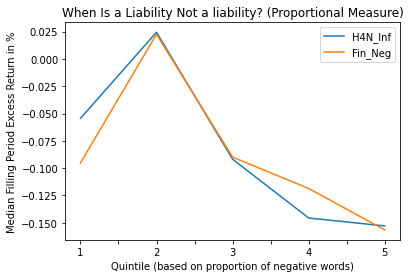

In [26]:
table_1_with_proportion = df.groupby('H4N_Inf_quantile')['excess_return'].median().to_frame('H4N_Inf').merge(
    df.groupby('Fin_Neg_quantile')['excess_return'].median().to_frame('Fin_Neg'), left_index=True, right_index=True)
table_1_with_proportion.index = (table_1_with_proportion.index+1).astype(str)
table_1_with_proportion = table_1_with_proportion*100 # write into percentage
table_1_with_proportion.plot()
plt.title('When Is a Liability Not a liability? (Proportional Measure)')
plt.ylabel('Median Filling Period Excess Return in %')
plt.xlabel('Quintile (based on proportion of negative words)')
plt.show()

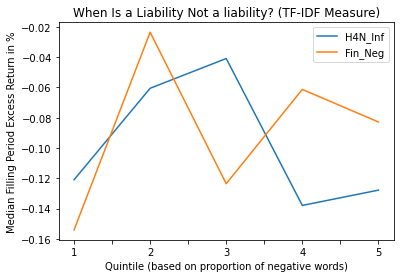

In [27]:
table_2_with_proportion = df.groupby('H4N_Inf_quantile_tfidf')['excess_return'].median().to_frame('H4N_Inf').merge(
    df.groupby('Fin_Neg_quantile_tfidf')['excess_return'].median().to_frame('Fin_Neg'), left_index=True, right_index=True)
table_2_with_proportion.index = (table_2_with_proportion.index+1).astype(str)
table_2_with_proportion = table_2_with_proportion*100 # write into percentage
table_2_with_proportion.plot()
plt.title('When Is a Liability Not a liability? (TF-IDF Measure)')
plt.ylabel('Median Filling Period Excess Return in %')
plt.xlabel('Quintile (based on proportion of negative words)')
plt.show()